In [9]:
# -----------------------------
# SETUP: Load and clean data
# -----------------------------
import pandas as pd
from plotnine import *
import geopandas as gpd

# Load data
indicator_1 = pd.read_csv("unicef_indicator_1.csv")
indicator_2 = pd.read_csv("unicef_indicator_2.csv")
metadata = pd.read_csv("unicef_metadata.csv")

# Clean 'obs_value'
indicator_1["obs_value"] = indicator_1["obs_value"].replace("<100", "100")
indicator_1["obs_value"] = pd.to_numeric(indicator_1["obs_value"], errors="coerce")

# Latest deprivation year
latest_year = indicator_2["time_period"].max()

# Filter deprivation data (total, latest year)
deprivation = indicator_2[
    (indicator_2["time_period"] == latest_year) & 
    (indicator_2["sex"] == "Total")
]


/var/folders/p4/7vfslhms6lzg_92qys684z7c0000gn/T/ipykernel_2554/39491163.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/var/folders/p4/7vfslhms6lzg_92qys684z7c0000gn/T/ipykernel_2554/39491163.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



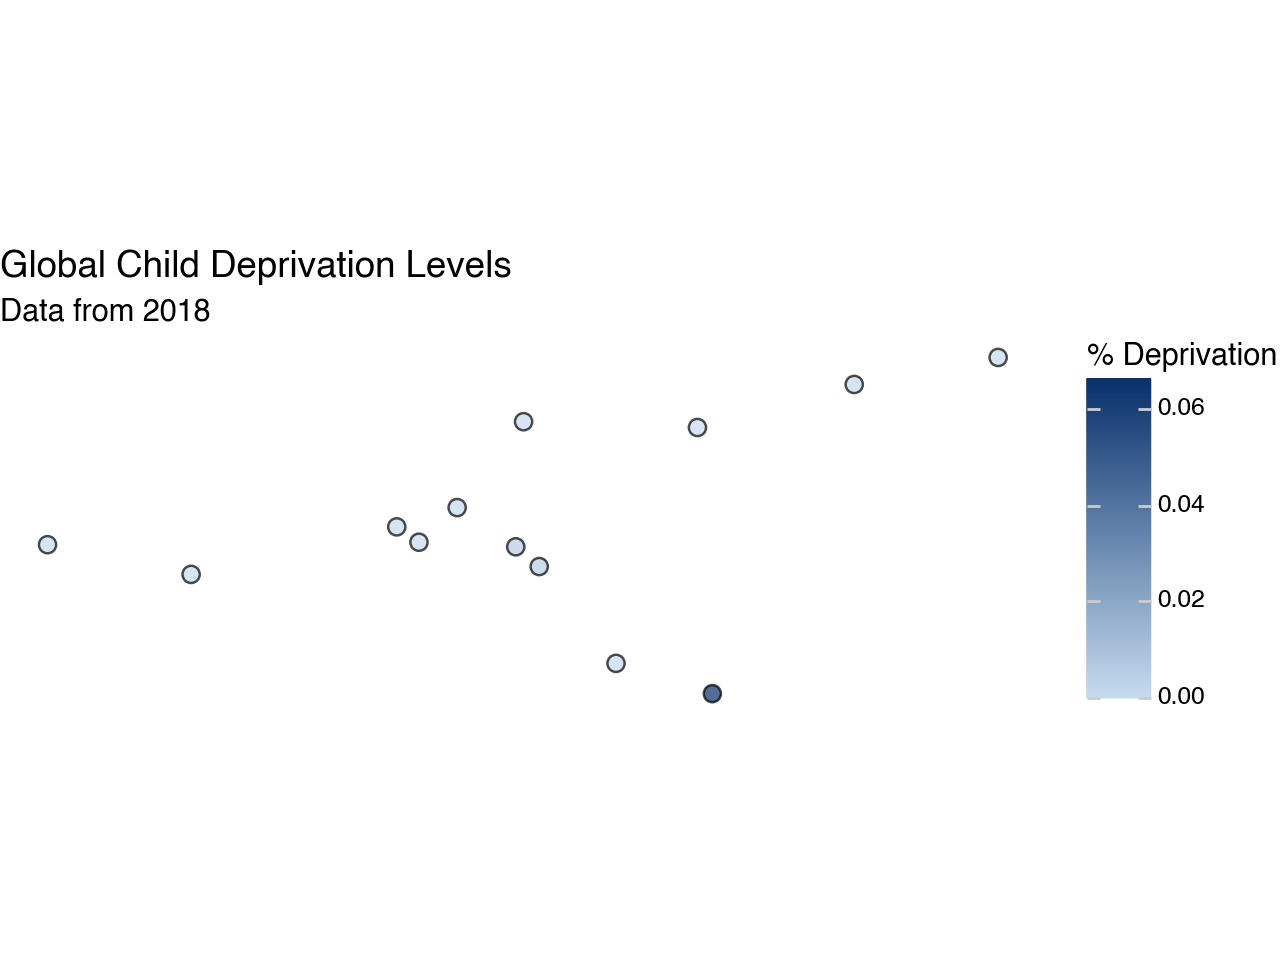

In [10]:
# Load and merge shapefile
world = gpd.read_file("ne_110m_admin_0_countries.shp")
world = world.rename(columns={"ADM0_A3": "alpha_3_code"})
world_data = world.merge(deprivation, on="alpha_3_code")

# Add centroid coordinates for plotting
world_data["long"] = world_data.geometry.centroid.x
world_data["lat"] = world_data.geometry.centroid.y

# Plot
(
    ggplot(world_data.dropna(subset=["obs_value"]), aes(x="long", y="lat", fill="obs_value")) +
    geom_point(size=3, color="black", alpha=0.7) +
    coord_fixed() +
    theme_void() +
    scale_fill_gradient(name="% Deprivation", low="#c6dbef", high="#08306b") +
    labs(title="Global Child Deprivation Levels", subtitle=f"Data from {latest_year}")
)


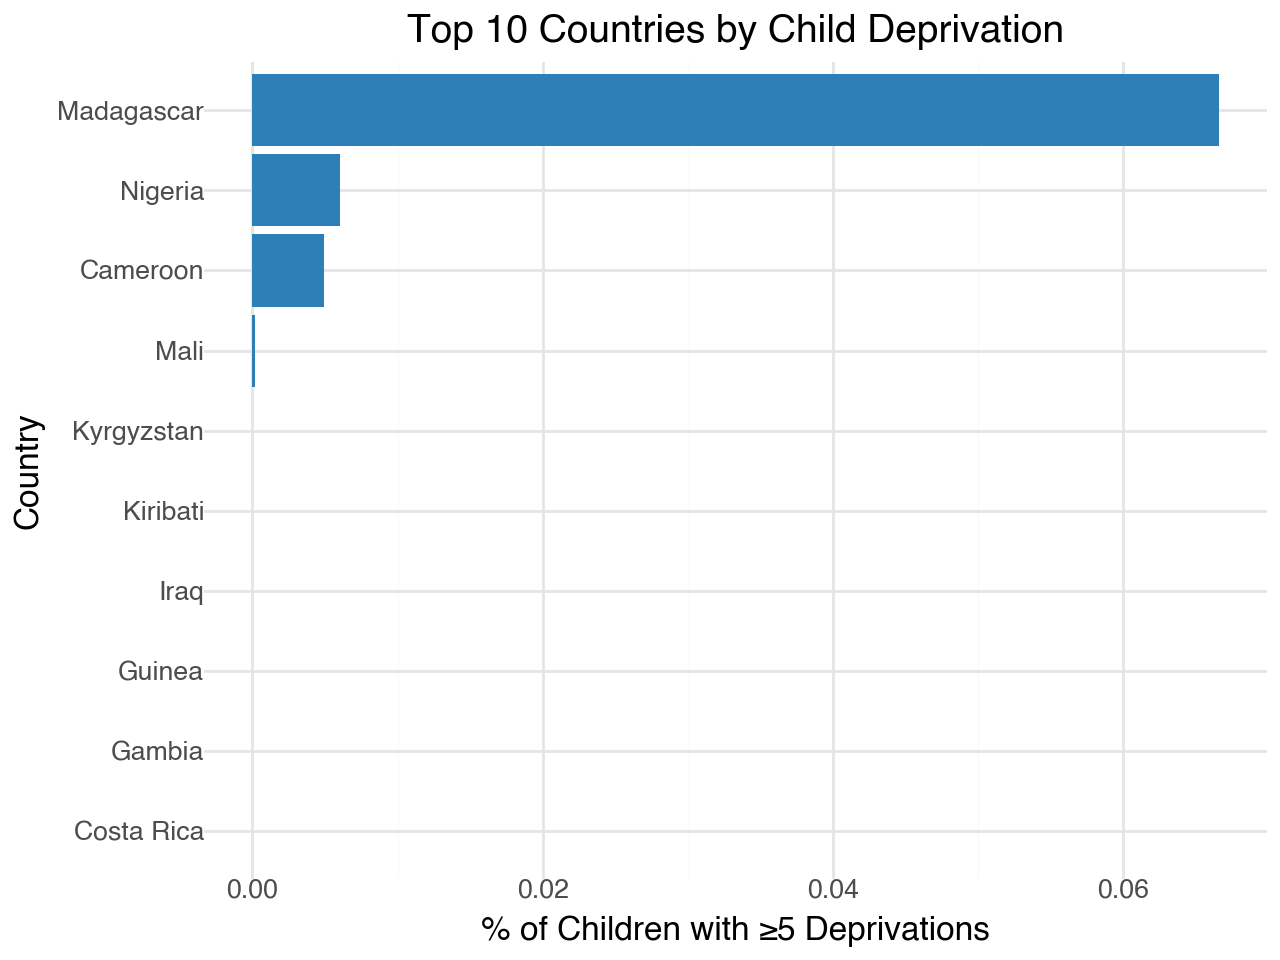

In [11]:
# Top 10 countries
top10 = deprivation.sort_values("obs_value", ascending=False).head(10)

(
    ggplot(top10, aes(x="reorder(country, obs_value)", y="obs_value")) +
    geom_col(fill="#2c7fb8") +
    coord_flip() +
    labs(
        title="Top 10 Countries by Child Deprivation",
        x="Country",
        y="% of Children with ≥5 Deprivations"
    ) +
    theme_minimal(base_size=12) +
    theme(
        axis_title=element_text(weight="bold"),
        plot_title=element_text(size=14, weight="bold")
    )
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 751 rows containing missing values.


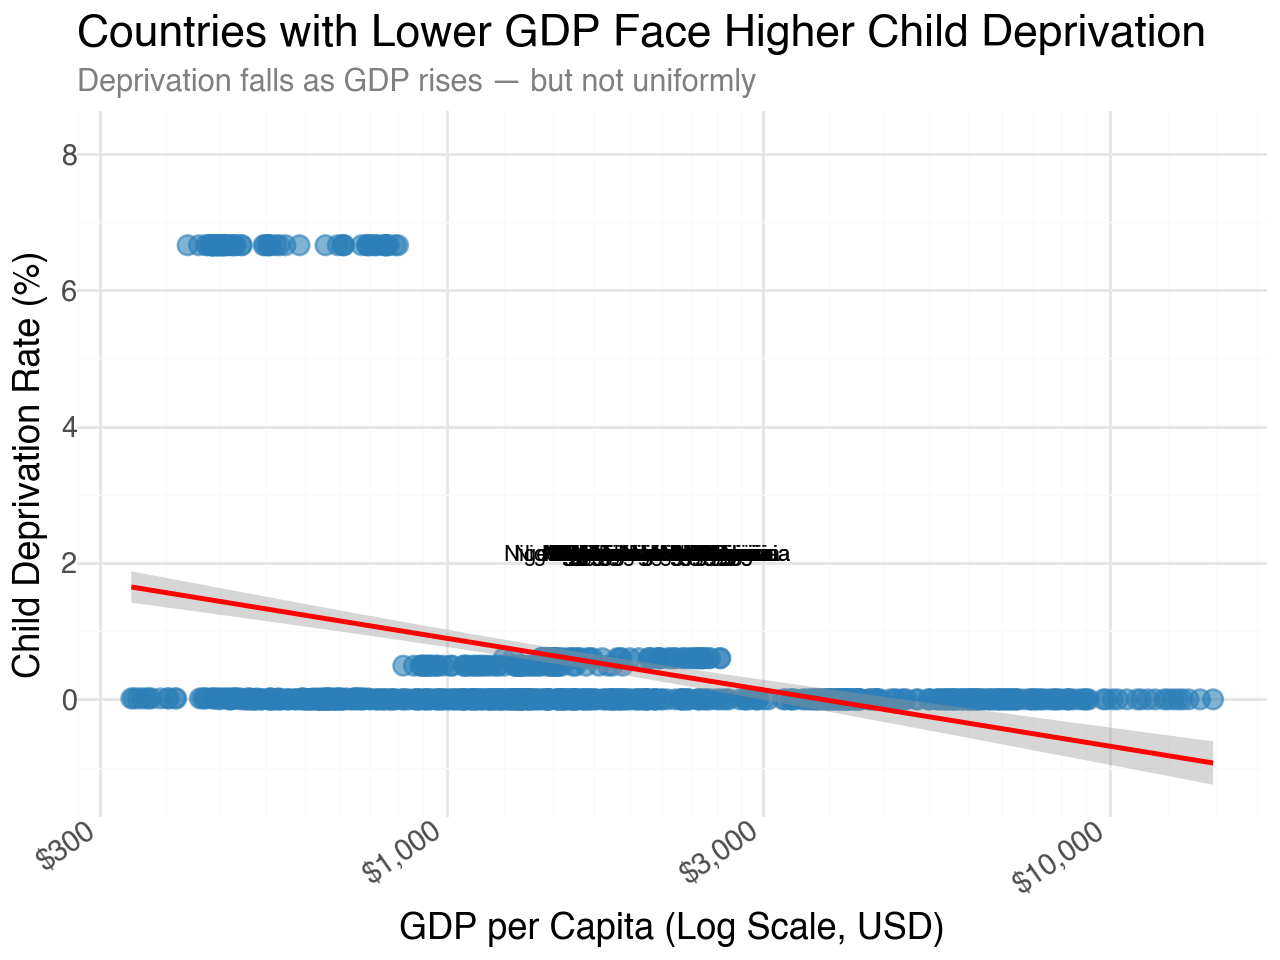

In [21]:
# Prepare the data
scatter = deprivation.merge(metadata, on="country")
scatter = scatter.dropna(subset=["obs_value", "GDP per capita (constant 2015 US$)"])
scatter = scatter.rename(columns={"GDP per capita (constant 2015 US$)": "GDP_per_capita"})
scatter["Deprivation_percent"] = scatter["obs_value"] * 100

# Cap very high values for clarity
scatter = scatter[scatter["Deprivation_percent"] < 60]

# Highlight specific countries (ensure names match exactly!)
highlighted = ["Nigeria", "India", "United States", "Ethiopia", "Bangladesh"]
scatter["label"] = scatter["country"].apply(lambda x: x if x in highlighted else None)

# Plot
(
    ggplot(scatter, aes(x="GDP_per_capita", y="Deprivation_percent")) +
    geom_point(size=3.5, color="#2c7fb8", alpha=0.6) +
    geom_smooth(method="lm", color="red", size=1) +
    geom_text(aes(label="label"), nudge_y=1.5, size=8, ha="left") +
    scale_x_log10(labels=lambda l: [f"${int(x):,}" for x in l]) +
    labs(
        title="Countries with Lower GDP Face Higher Child Deprivation",
        subtitle="Deprivation falls as GDP rises — but not uniformly",
        x="GDP per Capita (Log Scale, USD)",
        y="Child Deprivation Rate (%)"
    ) +
    theme_minimal(base_size=13) +
    theme(
        axis_title=element_text(weight="bold"),
        plot_title=element_text(size=16, weight="bold"),
        plot_subtitle=element_text(size=11, color="gray"),
        axis_text_x=element_text(rotation=35, ha="right")
    )
)


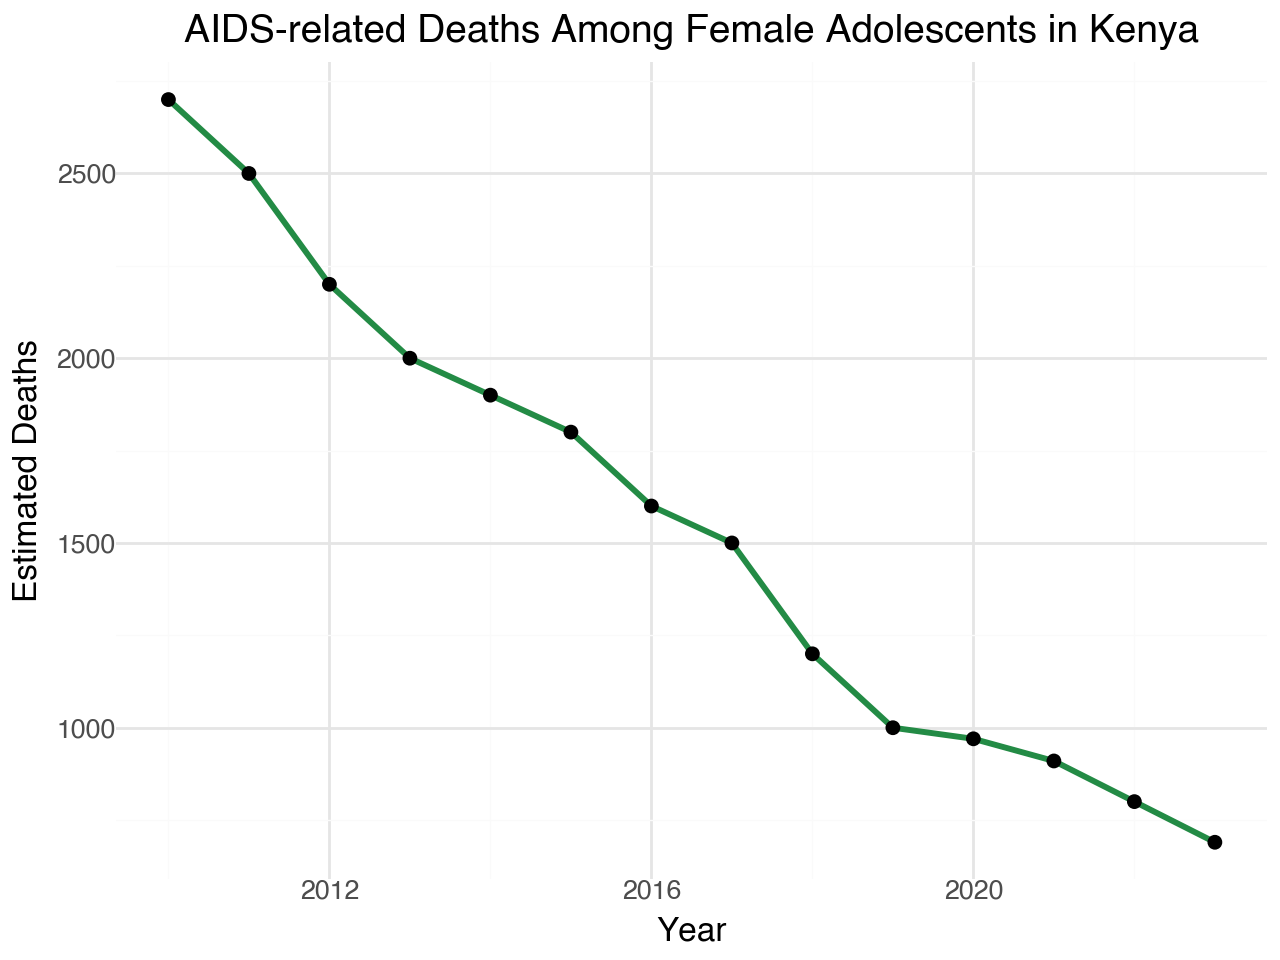

In [7]:
kenya = indicator_1[
    (indicator_1["country"] == "Kenya") &
    (indicator_1["sex"] == "Female") &
    (indicator_1["current_age"] == "10 to 19 years old")
]

(
    ggplot(kenya, aes(x="time_period", y="obs_value")) +
    geom_line(color="#238b45", size=1.2) +
    geom_point(color="black", size=2) +
    labs(
        title="AIDS-related Deaths Among Female Adolescents in Kenya",
        x="Year", y="Estimated Deaths"
    ) +
    theme_minimal(base_size=12) +
    theme(
        axis_title=element_text(weight="bold"),
        plot_title=element_text(size=14, weight="bold")
    )
)
